In [3]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = Path('./data_in/ts-course-data')
comp_dir = Path('./data_in/store-sales-time-series-forecasting')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

C:\Users\K\AppData\Local\Temp\ipykernel_11356\2011289050.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\K\AppData\Local\Temp\ipykernel_11356\2011289050.py:32: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [4]:
raw_book_sales = pd.read_csv('./data_in/ts-course-data/book_sales.csv')

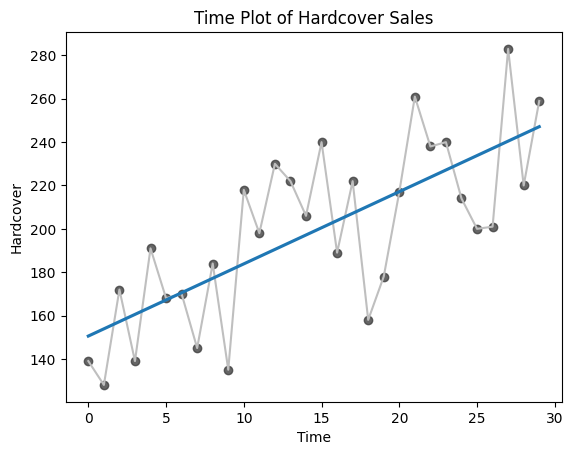

In [5]:
fig, ax = plt.subplots()

ax.plot('Time', 'Hardcover', data = book_sales, color = '0.75')
ax = sns.regplot(x = 'Time', y = 'Hardcover', data = book_sales, ci=None, scatter_kws = dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

In [6]:
# On average of 6 days.
# Hardcover = 3.33*Time +150.5
3.33*6+150.5

170.48

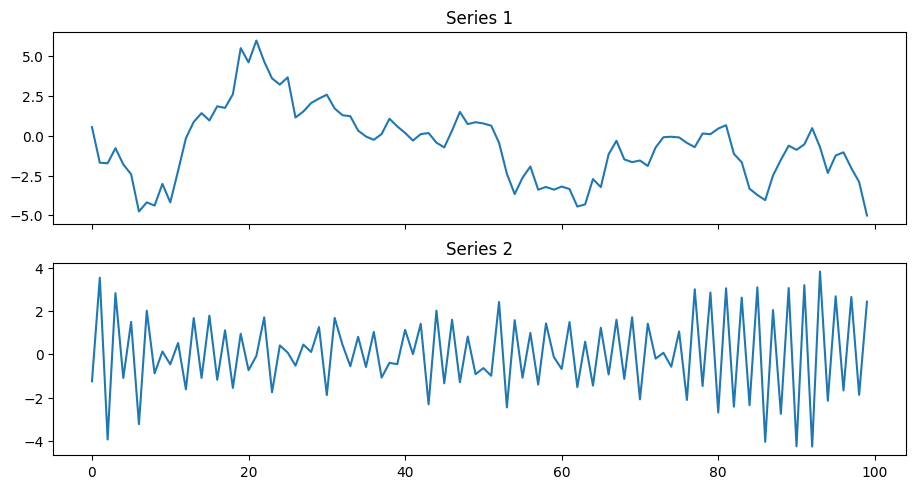

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

In [12]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

# Create a time dummy
time = np.arange(len(df.index))

df['time'] = time

X = df.loc[:,['time']]
y = df.loc[:, 'sales']

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index)

In [16]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

NameError: name 'plot_params' is not defined

In [28]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']]
X.dropna(inplace = True)  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X,y)
# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index = X.index)



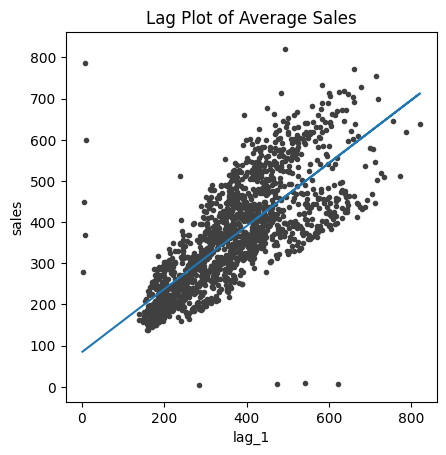

In [29]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y , '.', color = '0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect = 'equal', ylabel = 'sales', xlabel='lag_1', title='Lag Plot of Average Sales');

<Axes: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Day'>

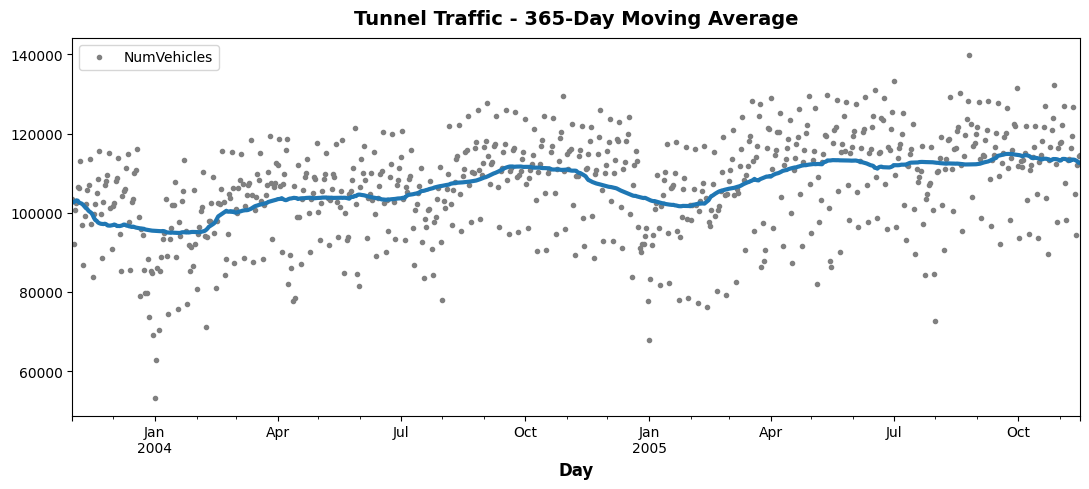

In [34]:
moving_average = tunnel.rolling(window = 91, # 365-day window
                                center = True, # average at the centre of the window
                                min_periods = 45, # Choose half the window size
                                ).mean()

ax = tunnel.plot(style = ".", color = "0.5")

moving_average.plot(ax=ax, linewidth = 3, title = "Tunnel Traffic - 365-Day Moving Average", legend = False)

In [29]:
from statsmodels.tsa.deterministic import DeterministicProcess
dp = DeterministicProcess(
    index = tunnel.index, # dates from the training data
    constant = True, # dummy feature for the bias(y_intercept)
    order = 4, # time dummy (trend) (2 for quadratic, 3 for cubic)
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed,trend**4
Day,,,,,
2003-11-01,1.0,1.0,1.0,1.0,1.0
2003-11-02,1.0,2.0,4.0,8.0,16.0
2003-11-03,1.0,3.0,9.0,27.0,81.0
2003-11-04,1.0,4.0,16.0,64.0,256.0
2003-11-05,1.0,5.0,25.0,125.0,625.0


In [30]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"] # Predictor

lm = LinearRegression(fit_intercept=False)
lm.fit(X,y)

y_pred = pd.Series(lm.predict(X), index=X.index)

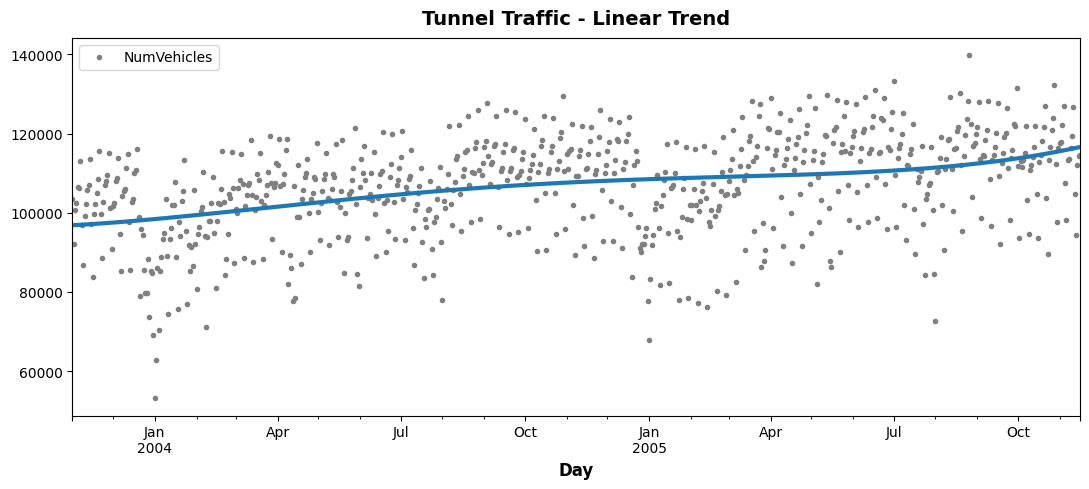

In [31]:
ax = tunnel.plot(style = ".", color = "0.5", title = "Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label = "Trend")

In [32]:
X = dp.out_of_sample(steps = 30)

y_fore = pd.Series(lm.predict(X), index = X.index)

y_fore.head()

2005-11-17    116670.853728
2005-11-18    116746.009386
2005-11-19    116821.762947
2005-11-20    116898.117724
2005-11-21    116975.077036
Freq: D, dtype: float64

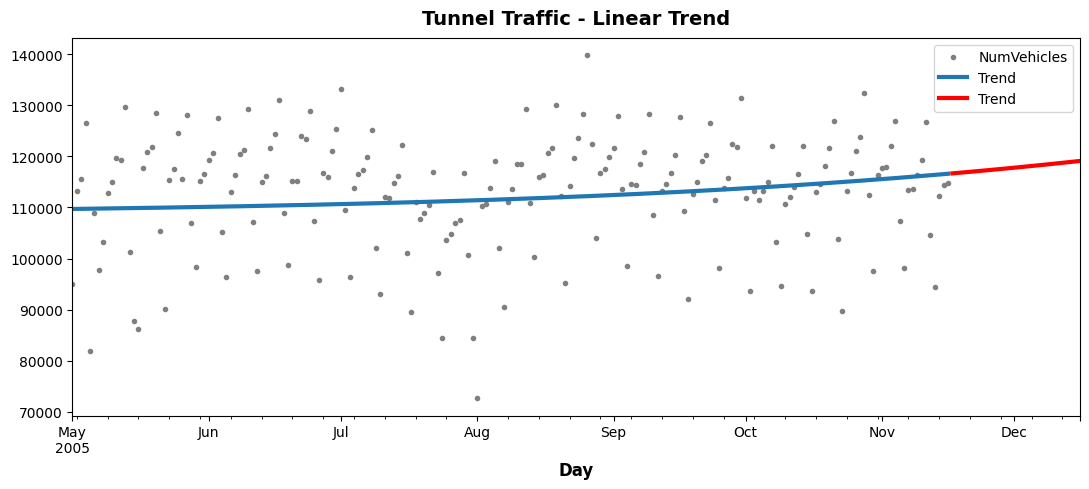

In [33]:
ax = tunnel["2005-05":].plot(style = ".", color = "0.5", title = "Tunnel Traffic - Linear Trend")
ax = y_pred["2005-05":].plot(ax=ax,linewidth=3, label = "Trend")
ax = y_fore.plot(ax=ax,linewidth=3, label = "Trend", color = "red")
_ = ax.legend()